## Filter NISKINe moorings time series to extract NIWs signal

In [1]:
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import xarray as xr
import gsw
import metpy
from pathlib import Path
import cartopy.crs as ccrs
import geopy.distance
import mplniw.utils as ut
import mplniw.sigp as sp
import matplotlib.gridspec as gridspec

import gvpy as gv

import niskine

In [2]:
#Load mooring coordinates and seafloor depth at the location
mooring = 3
conf = niskine.io.load_config()
lon, lat, bottom_depth = niskine.io.mooring_location(mooring=mooring)

In [3]:
root_dir = '/Users/zcasparcohen/codes/NIW/data/' #directory

In [4]:
print('Coriolis frequency',ut.coriolis(lat)*3600*24/(2*np.pi),'cpd')

Coriolis frequency 1.719572803747457 cpd


In [20]:
#Definition filter
dt = 1/(24*6)  # Time step in days unit
signal='bp'
if signal=='bp':
    Tw = 30  # Kernel length
    omega = ut.coriolis(lat)*3600*24/(2*np.pi)  # Central frequency
    bandwidth = 0.2
    h = ut.generate_filter(omega,dt=dt,T=Tw,bandwidth=bandwidth,lat=lat,pass_zero=False)  # Best filter
elif signal=='lp':
    fc=ut.coriolis(lat)*3600*24/(2*np.pi)  # Coriolis frequency
    omega = 1/(fc-0.2)  #Cutoff frequency
    bandwidth = None 
    h = ut.generate_filter(omega,dt=dt,T=Tw,bandwidth=bandwidth,lat=lat,pass_zero=True)  # Best filter
else:
    print('Filter not defined')
h_hat, w = ut.filter_response(h, dt=dt)  #Filter response

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


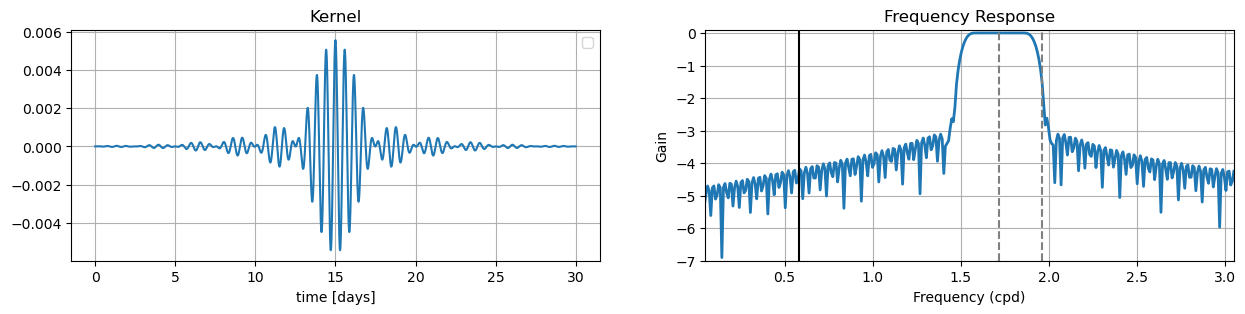

In [21]:
#Plot filter and response in the frequency domain
t = np.arange(0,Tw,dt)
fig, axes = plt.subplots(1,2, figsize=(15,3))
ax = axes[0]
ax.plot(t, h)
ax.grid()
ax.set_xlabel('time [days]')
ax.set_title('Kernel')
ax.legend()

ax = axes[1]

ax.plot(w, np.log10(abs(h_hat)), linewidth=2)
ax.axvline(1/omega, color='k')
#ax.axvline(omega-bandwidth, color='k',ls='--')
#ax.axvline(omega+bandwidth, color='k',ls='--')
ax.axvline(1.96, color='grey', ls='--')
ax.axvline(omega, color='grey', ls='--')
ax.set_xlabel('Frequency (cpd)')
ax.set_ylabel('Gain')
ax.set_title('Frequency Response')
#ax.set_ylim(-0.05, 1.05)
ax.set_ylim(-7, 0.1)
ax.set_xlim(0.05, 3.05)
ax.grid(True)

In [22]:
#Load moorings velocity fields
import mplniw.sigp as sp
gridded=xr.open_dataset(root_dir+'M%s_linear_merge_slinearfill.nc'%mooring)[['u','v']]
#ds = sp.wrap_filter(gridded,h,**{'hilbert':False})  #apply filter

In [23]:
if signal=='lp':
    gridded['usq'] = gridded.u**2
    gridded['vsq'] = gridded.v**2
    gridded['uv'] = gridded.u*gridded.v
    col = ['u','v','vsq','usq','uv']
elif signal=='bp':
    col=['u','v']

In [24]:
#Apply filter
ds = sp.wrap_filter(gridded,h,columns=col)

In [25]:
#Load mld
mld_m1 = xr.open_dataarray(conf.data.ml.mld).sel(time=slice(ds.time[0],ds.time[-1]))
ds['mld'] = mld_m1

In [27]:
# If needed add wkb correction
if True:
    wkb = niskine.clim.get_wkb_factors(gridded)
    ds['bpu_wkb'] = ds['u_filtered']*wkb
    ds['bpv_wkb'] = ds['v_filtered']*wkb
    ds.bpu_wkb.attrs.update({'long_name':'Zonal velocity', 'units':r'$m.s^{-1}$'})
    ds.bpv_wkb.attrs.update({'long_name':'Meridional velocity', 'units':r'$m.s^{-1}$'})
#if needed, interpolate flagged profiles using polynomial (best for high frequency signal)
if signal=='bp':
    ds['bpu_wkb'] = ds.bpu_wkb.sel(z=slice(10,1600)).interpolate_na('time',max_gap=pd.Timedelta(12, "h"),method='polynomial',order=7)
    ds['bpv_wkb'] = ds.bpv_wkb.sel(z=slice(10,1600)).interpolate_na('time',max_gap=pd.Timedelta(12, "h"),method='polynomial',order=7)
    ds['u_filtered'] = ds.u_filtered.sel(z=slice(10,1600)).interpolate_na('time',max_gap=pd.Timedelta(12, "h"),method='polynomial',order=7)
    ds['v_filtered'] = ds.v_filtered.sel(z=slice(10,1600)).interpolate_na('time',max_gap=pd.Timedelta(12, "h"),method='polynomial',order=7)
    ds['ni_ke_wkb'] = 0.5*(ds.bpu_wkb**2+ds.bpv_wkb**2)
    ds['ni_ke'] = 0.5*(ds.u_filtered**2+ds.v_filtered**2)

if signal=='lp':
    ds['ke'] = 0.5*(ds.u**2+ds.v**2)
    ds['eke'] = 0.5*((ds.u-ds.u.mean())**2+(ds.v-ds.v.mean())**2)
    ds.ke.attrs.update({'long_name':'Kinetic energy', 'units':r'$m^2.s^{-2}$'})
    ds.eke.attrs.update({'long_name':'Eddy Kinetic energy', 'units':r'$m^2.s^{-2}$'})

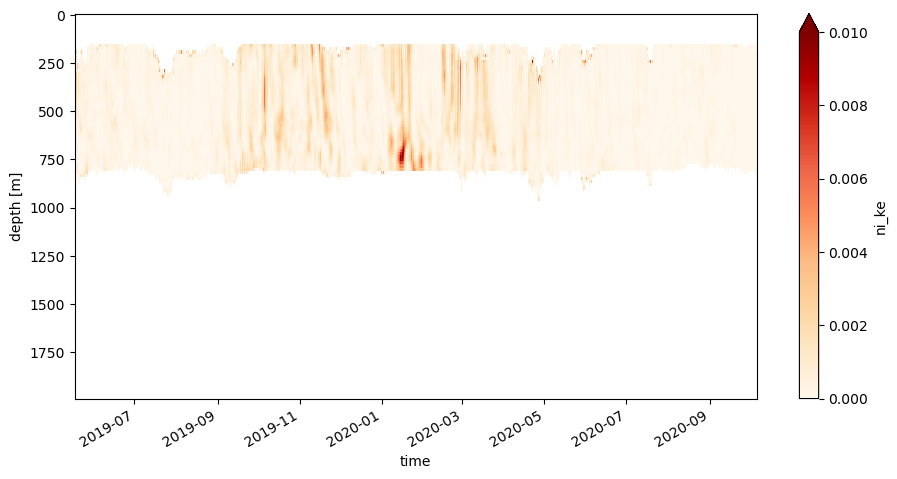

In [28]:
#plot variable to check for errors
fig,ax = plt.subplots(figsize=(11,5))
ds.ni_ke.plot(yincrease=False,cmap='OrRd',vmax=0.01)

In [9]:
#Save data; name should contain bandwidth/cutoff frequency (bp/lp) and mooring number
if signal=='bp':
    ds.to_netcdf(root_dir+'NI02_M%s.nc'%mooring)
if signal=='blp':
    ds.to_netcdf(root_dir+'M%s_lp15.nc'%mooring)